In [ ]:
# !pip uninstall tidyzoning -y
# !pip install git+https://github.com/HOUPU1993/tidyzoning.git

Found existing installation: tidyzoning 0.1.0
Uninstalling tidyzoning-0.1.0:
  Successfully uninstalled tidyzoning-0.1.0
  Cloning https://github.com/HOUPU1993/tidyzoning.git to c:\users\admin\appdata\local\temp\pip-req-build-_3jgd09j
  Resolved https://github.com/HOUPU1993/tidyzoning.git to commit 773522adeb44faebe8edbd9efc27c0d6ba2554cc
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for tidyzoning: filename=tidyzoning-0.1.0-py3-none-any.whl size=24669 sha256=1465b6a49d07a354300572f56d22835e590a3cf5197b0a16c815967462aeb58f
  Stored in directory: C:\Users\Admin\AppData\Local\Temp\pip-ephem-wheel-cache-zbwuthwg\wheels\f4\29\51\e431eb95e0bf6589310375ce483daada9c916a6f65f3b65a8f
Successfully built tidyzoning


  Running command git clone --filter=blob:none --quiet https://github.com/HOUPU1993/tidyzoning.git 'C:\Users\Admin\AppData\Local\Temp\pip-req-build-_3jgd09j'


In [ ]:
# pip install pandas==2.1.4 geopandas==0.14.2

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from shapely.geometry import Point
from shapely.geometry import box

# input my libraries
from tidyzoning import find_district_idx
from tidyzoning import find_bldg_type
from tidyzoning import check_land_use
from tidyzoning import get_zoning_req
from tidyzoning import check_fl_area
from tidyzoning import check_far
from tidyzoning import check_height
from tidyzoning import check_bedrooms
from tidyzoning import check_lot_coverage
from tidyzoning import check_unit_density
from tidyzoning import check_unit_size
from tidyzoning import add_setbacks
from tidyzoning import get_buildable_area
from tidyzoning import process_zoning_analysis
from tidyzoning import unify_tidybuilding

from tidyzoning.check_footprint import check_footprint

In [2]:
'''read the tidyzoning file'''

# Set the directory path
folder_path = r"C:\Users\Admin\Desktop\New folder (6)/ozfs"
# Get all GeoJSON files
geojson_files = [f for f in os.listdir(folder_path) if f.endswith('.geojson')]
# Read and merge all GeoJSON files
gdfs = [gpd.read_file(os.path.join(folder_path, file)) for file in geojson_files]
tidyzoning = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
tidyzoning = tidyzoning.to_crs(3857)
# Remove rows where geometry is None
tidyzoning = tidyzoning[tidyzoning["geometry"].notnull()].reset_index(drop=True)
tidyzoning

,dist_info,lot_constraints,structure_constraints,other_constraints,geometry
0,"{'muni_name': 'Addison', 'county_name': 'Dalla...","{'lot_size': [{'unit': 'acres', 'use_name': '1...","{'setback_side_int': [{'unit': 'feet', 'use_na...","{'parking_uncovered': [{'unit': 'stalls', 'use...","MULTIPOLYGON (((-10780184.101 3887684.743, -10..."
1,"{'muni_name': 'Addison', 'county_name': 'Dalla...","{'lot_size': [{'unit': 'acres', 'use_name': '1...","{'setback_side_int': [{'unit': 'feet', 'use_na...","{'parking_uncovered': [{'unit': 'stalls', 'use...","MULTIPOLYGON (((-10777090.621 3888246.808, -10..."
2,"{'muni_name': 'Addison', 'county_name': 'Dalla...","{'lot_size': [{'unit': 'acres', 'use_name': ['...","{'setback_front': [{'unit': 'feet', 'use_name'...","{'parking_uncovered': [{'unit': 'stalls', 'use...","MULTIPOLYGON (((-10778516.328 3891864.967, -10..."
3,"{'muni_name': 'Addison', 'county_name': 'Dalla...",[ ],[ ],[ ],"MULTIPOLYGON (((-10781846.642 3887084.891, -10..."
4,"{'muni_name': 'Addison', 'county_name': 'Dalla...",[ ],[ ],[ ],"MULTIPOLYGON (((-10778798.181 3888383.694, -10..."
...,...,...,...,...,...
276,"{'muni_name': 'Wilmer', 'county_name': 'Dallas...",[ ],[ ],[ ],"MULTIPOLYGON (((-10765169.099 3840332.940, -10..."
277,"{'muni_name': 'Wilmer', 'county_name': 'Dallas...",[ ],[ ],[ ],"MULTIPOLYGON (((-10762315.568 3840924.499, -10..."
278,"{'muni_name': 'Wilmer', 'county_name': 'Dallas...",[ ],[ ],[ ],"MULTIPOLYGON (((-10762375.540 3838491.586, -10..."
279,"{'muni_name': 'Wilmer', 'county_name': 'Dallas...","{'lot_size': [{'unit': 'acres', 'use_name': '1...","{'setback_front': [{'unit': 'feet', 'use_name'...","{'parking_uncovered': [{'unit': 'stalls', 'use...","POLYGON ((-10762154.504 3841742.144, -10762144..."


In [3]:
'''read the tidyparcel in Dallas'''
tidyparcel = gpd.read_file(r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel_filtered.geojson")
tidyparcel = tidyparcel.to_crs(3857)
tidyparcel

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,50_threshold,num_edges,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry
0,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.159790,False,4,NaN,True,3.135486,NaN,NaN,NaN,rear,"LINESTRING (-10752615.304 3893136.851, -107526..."
1,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.159790,False,4,NaN,True,1.564758,NaN,NaN,NaN,Interior side,"LINESTRING (-10752642.896 3893137.020, -107526..."
2,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.159790,False,4,NaN,False,-0.017483,NaN,NaN,NaN,front,"LINESTRING (-10752642.628 3893181.355, -107526..."
3,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.159790,False,4,NaN,True,-1.576837,NaN,NaN,NaN,Interior side,"LINESTRING (-10752615.038 3893180.873, -107526..."
4,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.159790,False,4,NaN,True,-1.576837,NaN,NaN,NaN,centroid,POINT (-10752628.983 3893159.025)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056237,26520460010300000,NaN,9999,6018 SHATTUCK DR,R,A11,regular inside parcel,True,Shattuck Dr,1.177974,False,4,1.864864,True,-0.241762,-1.775119,87.854918,32.194566,Interior side,"LINESTRING (-10760954.529 3891326.008, -107609..."
1056238,26520460010300000,NaN,9999,6018 SHATTUCK DR,R,A11,regular inside parcel,True,Shattuck Dr,1.177974,False,4,1.864864,False,-1.734068,-1.775119,2.352055,53.160020,rear,"LINESTRING (-10760914.174 3891316.057, -107609..."
1056239,26520460010300000,NaN,9999,6018 SHATTUCK DR,R,A11,regular inside parcel,True,Shattuck Dr,1.177974,False,4,1.864864,False,1.399021,-1.775119,1.864864,11.567482,front,"LINESTRING (-10760958.926 3891300.660, -107609..."
1056240,26520460010300000,NaN,9999,6018 SHATTUCK DR,R,A11,regular inside parcel,True,Shattuck Dr,1.177974,False,4,1.864864,True,3.028513,-1.775119,84.772121,33.190130,Interior side,"LINESTRING (-10760917.486 3891295.954, -107609..."


In [4]:
file_path = r"C:\Users\Admin\Desktop\New folder (6)\tidybuilding\2_fam/"
tidybuilding_2_fam = unify_tidybuilding(file_path)
tidybuilding_2_fam

,stories,height,width,depth,height_eave,type,fl_area,max_unit_size,min_unit_size,total_bedrooms,total_units,units_3bed,fl_area_bottom,fl_area_top,units_floor1,units_floor2,units_floor3
0,2.5,45,35,40,35,2-family,3126,1563,1563,6,2,2,3126,3126,2,0,0


In [ ]:
# tidybuilding = gpd.read_file(r"C:/Users\Admin/Desktop/zoning_data/Test_Data/Tidybuildings/tidybuilding_4family_tall.geojson")
# tidyparcel = gpd.read_file(r"C:/Users/Admin/Desktop/zoning_data/Test_Data/Test_Parcels/testparcel_100per_correct.geojson")
# tidyzoning = gpd.read_file(r"C:/Users\Admin/Desktop/zoning_data/Test_Data//Tidyzoning/adjusted_Azle_nza.geojson")

# tidyzoning = tidyzoning.to_crs(3857)
# tidyparcel = tidyparcel.to_crs(3857)
# tidybuilding = tidybuilding.to_crs(3857)

In [ ]:
# import folium

# base_map = tidyparcel.explore(column='side')

# tidyzoning.explore(
#     m=base_map, 
#     alpha=0.2,   
#     color='blue' 
# )

## Create Different Functions

### `find_district_idx` function

In [5]:
find_district_idx_results = find_district_idx(tidyparcel, tidyzoning)
find_district_idx_results

,prop_id,parcel_id,zoning_id
4,480013500B25R0000,10,217
10,480116400B0140000,100,202
15,26578600090120000,10001,130
21,26074460100100000,10002,130
29,26520460030070000,10005,130
...,...,...,...
1056221,14030500120120000,99950,31
1056226,14030500120040000,99951,31
1056231,26074450160100000,9997,130
1056236,26074450160210000,9998,130


### `find_bldg_type` function

In [6]:
find_bldg_type_results = find_bldg_type(tidybuilding_2_fam)
find_bldg_type_results

'2_family'

### `get_zoning_req` function  
- `find_bldg_type` functiona is integrated internally.

In [ ]:
# import geopandas as gpd
# import pandas as pd
# from shapely.ops import unary_union
# from shapely.geometry import Polygon
# from shapely.ops import polygonize

# def extract_info(tidybuilding, tidyzoning, tidyparcel=None):
#     """
#     处理建筑、区划和地块信息，生成结构化的 Zoning 需求数据。
    
#     :param tidybuilding: 建筑数据 (DataFrame)
#     :param tidyzoning: 区划数据 (DataFrame)
#     :param tidyparcel: 地块数据 (GeoDataFrame)，可选
#     :return: 一个字典，包含所有计算的结果
#     """
#     # 提取 district constraints 数据
#     columns_to_extract = ['structure_constraints', 'other_constraints', 'lot_constraints']
#     extracted_data = []

#     for col in columns_to_extract:
#         for index, row in tidyzoning.iterrows():
#             constraints = row[col]
#             if isinstance(constraints, dict):  # 确保是字典
#                 for constraint_type, entries in constraints.items():
#                     if isinstance(entries, list):  # 遍历键值对应的列表
#                         for entry in entries:
#                             flattened_entry = {
#                                 "original_index": index,
#                                 "source_column": col,
#                                 "constraint_type": constraint_type,
#                             }
#                             # 将 entry 中的所有键值对保存
#                             for key, value in entry.items():
#                                 flattened_entry[key] = value  # 直接保存 value，不展开

#                             # 添加结果到列表
#                             extracted_data.append(flattened_entry)

#     # 转换为 DataFrame
#     district_constraints = pd.DataFrame(extracted_data)

#     # 检查 tidyparcel 是否存在并运行主逻辑
#     if tidyparcel is None:
#         lot_width = None
#         lot_depth = None
#         lot_area = None
#     else:
#         # 按地块处理
#         results = []
#         for prop_id, group in tidyparcel.groupby('Prop_ID'):
#             front_of_parcel = group[group['side'] == "front"]
#             side_of_parcel = group[group['side'] == "Interior side"]
#             parcel_without_centroid = group[(group['side'].notna()) & (group['side'] != "centroid")]
#             # 计算宽度和深度
#             lot_width = front_of_parcel.geometry.length.sum() * 3.28084  # 转换为英尺
#             lot_depth = side_of_parcel.geometry.length.sum() * 3.28084  # 转换为英尺
#             # 合并地块边界，并计算面积
#             polygons = polygonize(unary_union(parcel_without_centroid.geometry))
#             lot_polygon = unary_union(polygons) 
#             lot_area = lot_polygon.area * 10.7639  # 转换为平方英尺
#             results.append({
#                 "Prop_ID": prop_id,
#                 "lot_width": lot_width,
#                 "lot_depth": lot_depth,
#                 "lot_area": lot_area
#             })
#         # 转换为 DataFrame 以便后续使用
#         parcel_results = pd.DataFrame(results)

#         # 从 parcel_results 提取信息
#         lot_width = parcel_results["lot_width"].iloc[0] if not parcel_results.empty else None
#         lot_depth = parcel_results["lot_depth"].iloc[0] if not parcel_results.empty else None
#         lot_area = parcel_results["lot_area"].iloc[0] if not parcel_results.empty else None

#     # 检查 tidybuilding的数据
#     bed_list = {
#         'units_0bed': 0,
#         'units_1bed': 1,
#         'units_2bed': 2,
#         'units_3bed': 3,
#         'units_4bed': 4
#     }
#     bedrooms = max([bed_list.get(col, 0) for col in tidybuilding.columns if col in bed_list.keys()])
#     units_0bed = tidybuilding['units_0bed'].sum() if 'units_0bed' in tidybuilding.columns else 0
#     units_1bed = tidybuilding['units_1bed'].sum() if 'units_1bed' in tidybuilding.columns else 0
#     units_2bed = tidybuilding['units_2bed'].sum() if 'units_2bed' in tidybuilding.columns else 0
#     units_3bed = tidybuilding['units_3bed'].sum() if 'units_3bed' in tidybuilding.columns else 0
#     units_4bed = tidybuilding['units_4bed'].sum() if 'units_4bed' in tidybuilding.columns else 0
#     total_units = units_0bed + units_1bed + units_2bed + units_3bed + units_4bed
#     fl_area = tidybuilding.get('fl_area', [None])[0]
#     fl_area_top = tidybuilding.get('fl_area_top', [None])[0]
#     fl_area_bottom = tidybuilding.get('fl_area_bottom', [None])[0]
#     height = tidybuilding.get('height', [None])[0]
#     height_eave = tidybuilding.get('height_eave', [None])[0]
#     floors = tidybuilding.get('stories', [None])[0]
#     min_unit_size = tidybuilding.get('min_unit_size', [None])[0]
#     max_unit_size = tidybuilding.get('max_unit_size', [None])[0]
#     parking_enclosed = tidybuilding.get('parking_enclosed', [None])[0]
#     parking_covered = tidybuilding.get('parking_covered', [None])[0]
#     parking_uncovered = tidybuilding.get('parking_uncovered', [None])[0]
#     parking_floors = tidybuilding.get('parking_floors', [None])[0]
#     garage_entry = tidybuilding.get('garage_entry', [None])[0]
#     units_floor1 = tidybuilding.get('units_floor1', [None])[0]
#     units_floor2 = tidybuilding.get('units_floor2', [None])[0]
#     units_floor3 = tidybuilding.get('units_floor3', [None])[0]
#     far = fl_area / lot_area if lot_area is not None else None    

#     # 汇总结果
#     results = {
#         # From tidyzoning
#         "district_constraints": district_constraints, 
#         # From tidyparcel
#         "lot_width": lot_width, 
#         "lot_depth": lot_depth,
#         "lot_area": lot_area,
#         # From tidybuilding
#         "bedrooms": bedrooms, 
#         "units_0bed": units_0bed,
#         "units_1bed": units_1bed,
#         "units_2bed": units_2bed,
#         "units_3bed": units_3bed,
#         "units_4bed": units_4bed,
#         "total_units": total_units,
#         "fl_area": fl_area,
#         "fl_area_top": fl_area_top,
#         "fl_area_bottom": fl_area_bottom,
#         "height": height,
#         "height_eave": height_eave,
#         "floors": floors,
#         "min_unit_size": min_unit_size,
#         "max_unit_size": max_unit_size,
#         "parking_enclosed": parking_enclosed,
#         "parking_covered": parking_covered,
#         "parking_uncovered": parking_uncovered,
#         "parking_floors": parking_floors,
#         "garage_entry": garage_entry,
#         "units_floor1": units_floor1,
#         "units_floor2": units_floor2,
#         "units_floor3": units_floor3,
#         # Combined tidy zoning and tidyparcel together
#         "far": far           
#     }
#     return results


# result = extract_info(tidybuilding_2_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
# print(result)
# result['district_constraints'][result['district_constraints']['original_index'] == 2]

{'district_constraints':       original_index          source_column   constraint_type         unit  \
0                  0  structure_constraints  setback_side_int         feet   
1                  0  structure_constraints  setback_side_ext         feet   
2                  0  structure_constraints  setback_side_sum         feet   
3                  0  structure_constraints           stories      stories   
4                  0  structure_constraints         unit_size  square feet   
...              ...                    ...               ...          ...   
1255             274        lot_constraints          lot_size        acres   
1256             275        lot_constraints          lot_size        acres   
1257             279        lot_constraints          lot_size        acres   
1258             279        lot_constraints          lot_size        acres   
1259             280        lot_constraints          lot_size        acres   

                             use_name 

,original_index,source_column,constraint_type,unit,use_name,min_val,max_val
11,2,structure_constraints,setback_front,feet,"[2_family, 3_family, 4_family, Townhome]",{'expression': '30'},NaN
12,2,structure_constraints,setback_side_int,feet,"[2_family, 3_family, 4_family, Townhome]",{'expression': 'NA'},NaN
13,2,structure_constraints,setback_side_ext,feet,"[2_family, 3_family]",{'expression': '30'},NaN
14,2,structure_constraints,setback_rear,feet,"[2_family, 3_family]",{'expression': '25'},NaN
15,2,structure_constraints,stories,stories,"[2_family, 3_family, 4_family, Townhome]",NaN,{'expression': '2'}
16,2,structure_constraints,unit_size,square feet,"[2_family, 3_family, 4_family, Townhome]",{'expression': 'NA'},NaN
964,2,other_constraints,parking_uncovered,stalls,"[2_family, 3_family, 4_family, Townhome]",{'expression': 'units_0bed + 1.5 * units_1bed ...,NaN
1108,2,lot_constraints,lot_size,acres,"[2_family, 3_family, 4_family, Townhome]",{'expression': '1'},NaN


In [7]:
get_zoning_req_results = get_zoning_req(tidybuilding_2_fam, tidyzoning.loc[[2]], tidyparcel[tidyparcel['parcel_id'] == '10'])
get_zoning_req_results

,constraint_type,spec_type,min_value,max_value,unit
0,structure_constraints,setback_front,30.0,NaN,feet
1,structure_constraints,setback_side_ext,30.0,NaN,feet
2,structure_constraints,setback_rear,25.0,NaN,feet
3,structure_constraints,stories,NaN,2.0,stories
4,other_constraints,parking_uncovered,5.0,NaN,stalls
5,lot_constraints,lot_size,1.0,NaN,acres


### `Check` function

#### 01. `check_land_use` function
- `find_bldg_type` function is integrated internally.

In [8]:
check_land_use_results = check_land_use(tidybuilding_2_fam, tidyzoning)
check_land_use_results

,zoning_id,allowed
0,0,False
1,1,False
2,2,True
3,3,False
4,4,False
...,...,...
276,276,False
277,277,False
278,278,False
279,279,False


#### 02. `check_fl_area` function
- `get_zoning_req` function is integrated internally.

In [9]:
check_fl_area_result = check_fl_area(tidybuilding_2_fam, tidyzoning)
check_fl_area_result

,zoning_id,allowed
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True
...,...,...
276,276,True
277,277,True
278,278,True
279,279,True


#### 03. `check_far` function
- `get_zoning_req` function is integrated internally.

In [10]:
check_far_results = check_far(tidybuilding_2_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
check_far_results

,parcel_id,zoning_id,allowed
0,10,0,True
1,10,1,True
2,10,2,True
3,10,3,True
4,10,4,True
...,...,...,...
276,10,276,True
277,10,277,True
278,10,278,True
279,10,279,True


#### 04. `check_height` function
- `get_zoning_req` function is integrated internally.

In [11]:
check_height_result = check_height(tidybuilding_2_fam, tidyzoning)
check_height_result

,zoning_id,allowed
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True
...,...,...
276,276,True
277,277,True
278,278,True
279,279,True


#### 05. `check_bedrooms` function
- `get_zoning_req` function is integrated internally.

In [13]:
check_bedrooms_result = check_bedrooms(tidybuilding_2_fam, tidyzoning)
check_bedrooms_result

,zoning_id,allowed
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True
...,...,...
276,276,True
277,277,True
278,278,True
279,279,True


#### 06. `check_lot_coverage` function
- `get_zoning_req` function is integrated internally.

In [12]:
check_lot_coverage_result = check_lot_coverage(tidybuilding_2_fam, tidyzoning, tidyparcel[tidyparcel['parcel_id'] == '10'])
check_lot_coverage_result

,parcel_id,zoning_id,allowed
0,10,0,True
1,10,1,True
2,10,2,True
3,10,3,True
4,10,4,True
...,...,...,...
276,10,276,True
277,10,277,True
278,10,278,True
279,10,279,True


#### 07. `check_unit_density` function
- `get_zoning_req` function is integrated internally.

In [13]:
check_unit_density_result = check_unit_density(tidybuilding_2_fam, tidyzoning)
check_unit_density_result

,zoning_id,allowed
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True
...,...,...
276,276,True
277,277,True
278,278,True
279,279,True


#### 08. `check_unit_size` function
- `get_zoning_req` function is integrated internally.

In [14]:
check_unit_size_result = check_unit_size(tidybuilding_2_fam, tidyzoning)
check_unit_size_result

,zoning_id,allowed
0,0,True
1,1,True
2,2,True
3,3,True
4,4,True
...,...,...
276,276,True
277,277,True
278,278,True
279,279,True


### `add_setbacks` function
- `get_zoning_req` function is integrated internally.

In [15]:
# Example usage:
add_setbacks_results = add_setbacks(tidybuilding_2_fam, tidyzoning.loc[[2]], tidyparcel[tidyparcel['parcel_id'] == '10'])
add_setbacks_results

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,...,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry,setback,unit
0,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.15979,...,NaN,True,3.135486,NaN,NaN,NaN,rear,"LINESTRING (-10752615.304 3893136.851, -107526...",25.0,feet
1,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.15979,...,NaN,True,1.564758,NaN,NaN,NaN,Interior side,"LINESTRING (-10752642.896 3893137.020, -107526...",None,None
2,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.15979,...,NaN,False,-0.017483,NaN,NaN,NaN,front,"LINESTRING (-10752642.628 3893181.355, -107526...",30.0,feet
3,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.15979,...,NaN,True,-1.576837,NaN,NaN,NaN,Interior side,"LINESTRING (-10752615.038 3893180.873, -107526...",None,None


### `get_buildable_area` function
- `get_zoning_req` function is integrated internally.

In [16]:
tidyparcel_with_setbacks = add_setbacks(tidybuilding_2_fam,  tidyzoning.loc[[12]], tidyparcel[tidyparcel['parcel_id'] == '12492'])
tidyparcel_with_setbacks

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,...,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry,setback,unit
59673,26581500050100000,NaN,12492,610 MILKY WAY,R,A11,regular inside parcel,True,Milky Way,1.202713,...,0.000548,False,3.130871,-0.013213,0.142743,53.377753,rear,"LINESTRING (-10756091.979 3885558.770, -107561...",10.0,feet
59674,26581500050100000,NaN,12492,610 MILKY WAY,R,A11,regular inside parcel,True,Milky Way,1.202713,...,0.000548,True,1.545836,-0.013213,89.326954,30.182223,Interior side,"LINESTRING (-10756114.698 3885559.014, -107561...",None,None
59675,26581500050100000,NaN,12492,610 MILKY WAY,R,A11,regular inside parcel,True,Milky Way,1.202713,...,0.000548,True,-1.588572,-0.013213,89.738586,30.154028,Interior side,"LINESTRING (-10756091.155 3885605.154, -107560...",None,None
59676,26581500050100000,NaN,12492,610 MILKY WAY,R,A11,regular inside parcel,True,Milky Way,1.202713,...,0.000548,False,-0.013223,-0.013213,0.000548,6.958498,front,"LINESTRING (-10756113.539 3885605.450, -107560...",None,None


In [17]:
get_buildable_area_result = get_buildable_area(tidyparcel_with_setbacks)
get_buildable_area_result

,Prop_ID,parcel_id,buildable_geometry
0,26581500050100000,12492,"POLYGON ((-10756114.622 3885562.061, -10756113..."


C:\Users\Admin\AppData\Local\Temp\ipykernel_22020\3944427994.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


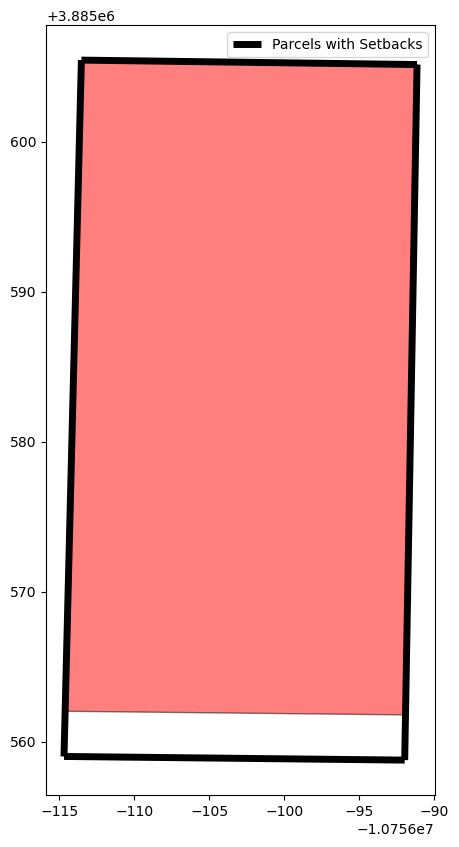

In [18]:
import matplotlib.pyplot as plt
# Create a map for overlay visualization
fig, ax = plt.subplots(figsize=(10, 10))
# Plot `tidyparcel_with_setbacks`, setting color and transparency
tidyparcel_with_setbacks.plot(ax=ax, color=None, alpha=1, edgecolor='black', linewidth=5, label='Parcels with Setbacks')
# Plot `get_buildable_area_result`, using different color and transparency
get_buildable_area_result.plot(ax=ax, color='red', alpha=0.5, edgecolor='black', label='Buildable Area')
# Add legend
ax.legend()
# Show the map
plt.show()

### `check_footprint()` function
- Based on Matt's Way

In [19]:
check_footprint_results = check_footprint(get_buildable_area_result, tidybuilding_2_fam)
check_footprint_results

Processing Parcels: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


,Prop_ID,parcel_id,allowed
0,26581500050100000,12492,False


## Test in Dallas County

#### Read the data

In [20]:
'''read the tidyzoning file'''

# Set the directory path
folder_path = r"C:\Users\Admin\Desktop\New folder (6)/ozfs"
# Get all GeoJSON files
geojson_files = [f for f in os.listdir(folder_path) if f.endswith('.geojson')]
# Read and merge all GeoJSON files
gdfs = [gpd.read_file(os.path.join(folder_path, file)) for file in geojson_files]
tidyzoning = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
tidyzoning = tidyzoning.to_crs(3857)
# Remove rows where geometry is None
tidyzoning = tidyzoning[tidyzoning["geometry"].notnull()].reset_index(drop=True)
tidyzoning

,dist_info,lot_constraints,structure_constraints,other_constraints,geometry
0,"{'muni_name': 'Addison', 'county_name': 'Dalla...","{'lot_size': [{'unit': 'acres', 'use_name': '1...","{'setback_side_int': [{'unit': 'feet', 'use_na...","{'parking_uncovered': [{'unit': 'stalls', 'use...","MULTIPOLYGON (((-10780184.101 3887684.743, -10..."
1,"{'muni_name': 'Addison', 'county_name': 'Dalla...","{'lot_size': [{'unit': 'acres', 'use_name': '1...","{'setback_side_int': [{'unit': 'feet', 'use_na...","{'parking_uncovered': [{'unit': 'stalls', 'use...","MULTIPOLYGON (((-10777090.621 3888246.808, -10..."
2,"{'muni_name': 'Addison', 'county_name': 'Dalla...","{'lot_size': [{'unit': 'acres', 'use_name': ['...","{'setback_front': [{'unit': 'feet', 'use_name'...","{'parking_uncovered': [{'unit': 'stalls', 'use...","MULTIPOLYGON (((-10778516.328 3891864.967, -10..."
3,"{'muni_name': 'Addison', 'county_name': 'Dalla...",[ ],[ ],[ ],"MULTIPOLYGON (((-10781846.642 3887084.891, -10..."
4,"{'muni_name': 'Addison', 'county_name': 'Dalla...",[ ],[ ],[ ],"MULTIPOLYGON (((-10778798.181 3888383.694, -10..."
...,...,...,...,...,...
276,"{'muni_name': 'Wilmer', 'county_name': 'Dallas...",[ ],[ ],[ ],"MULTIPOLYGON (((-10765169.099 3840332.940, -10..."
277,"{'muni_name': 'Wilmer', 'county_name': 'Dallas...",[ ],[ ],[ ],"MULTIPOLYGON (((-10762315.568 3840924.499, -10..."
278,"{'muni_name': 'Wilmer', 'county_name': 'Dallas...",[ ],[ ],[ ],"MULTIPOLYGON (((-10762375.540 3838491.586, -10..."
279,"{'muni_name': 'Wilmer', 'county_name': 'Dallas...","{'lot_size': [{'unit': 'acres', 'use_name': '1...","{'setback_front': [{'unit': 'feet', 'use_name'...","{'parking_uncovered': [{'unit': 'stalls', 'use...","POLYGON ((-10762154.504 3841742.144, -10762144..."


In [21]:
'''read the tidyparcel in Dallas'''
tidyparcel = gpd.read_file(r"C:\Users\Admin\Desktop\New folder (6)\tidyparcel_filtered.geojson")
tidyparcel = tidyparcel.to_crs(3857)
tidyparcel

,Prop_ID,GEO_ID,parcel_id,parcel_addr,landuse,landuse_spec,parcel_label,Found_Match,match_road_address,shape_index,50_threshold,num_edges,angle_difference,shared_side,parcel_bearing,road_bearing,angle,distance_to_road,side,geometry
0,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.159790,False,4,NaN,True,3.135486,NaN,NaN,NaN,rear,"LINESTRING (-10752615.304 3893136.851, -107526..."
1,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.159790,False,4,NaN,True,1.564758,NaN,NaN,NaN,Interior side,"LINESTRING (-10752642.896 3893137.020, -107526..."
2,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.159790,False,4,NaN,False,-0.017483,NaN,NaN,NaN,front,"LINESTRING (-10752642.628 3893181.355, -107526..."
3,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.159790,False,4,NaN,True,-1.576837,NaN,NaN,NaN,Interior side,"LINESTRING (-10752615.038 3893180.873, -107526..."
4,480013500B25R0000,NaN,10,6725 TY CIR,R,A11,no_match_address_standard,False,NaN,1.159790,False,4,NaN,True,-1.576837,NaN,NaN,NaN,centroid,POINT (-10752628.983 3893159.025)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056237,26520460010300000,NaN,9999,6018 SHATTUCK DR,R,A11,regular inside parcel,True,Shattuck Dr,1.177974,False,4,1.864864,True,-0.241762,-1.775119,87.854918,32.194566,Interior side,"LINESTRING (-10760954.529 3891326.008, -107609..."
1056238,26520460010300000,NaN,9999,6018 SHATTUCK DR,R,A11,regular inside parcel,True,Shattuck Dr,1.177974,False,4,1.864864,False,-1.734068,-1.775119,2.352055,53.160020,rear,"LINESTRING (-10760914.174 3891316.057, -107609..."
1056239,26520460010300000,NaN,9999,6018 SHATTUCK DR,R,A11,regular inside parcel,True,Shattuck Dr,1.177974,False,4,1.864864,False,1.399021,-1.775119,1.864864,11.567482,front,"LINESTRING (-10760958.926 3891300.660, -107609..."
1056240,26520460010300000,NaN,9999,6018 SHATTUCK DR,R,A11,regular inside parcel,True,Shattuck Dr,1.177974,False,4,1.864864,True,3.028513,-1.775119,84.772121,33.190130,Interior side,"LINESTRING (-10760917.486 3891295.954, -107609..."


In [22]:
file_path = r"C:\Users\Admin\Desktop\New folder (6)\tidybuilding\2_fam/"
tidybuilding_2_fam = unify_tidybuilding(file_path)
tidybuilding_2_fam

,stories,height,width,depth,height_eave,type,fl_area,max_unit_size,min_unit_size,total_bedrooms,total_units,units_3bed,fl_area_bottom,fl_area_top,units_floor1,units_floor2,units_floor3
0,2.5,45,35,40,35,2-family,3126,1563,1563,6,2,2,3126,3126,2,0,0


In [23]:
file_path = r"C:\Users\Admin\Desktop\New folder (6)\tidybuilding\4_fam_tall/"
tidybuilding_4_fam_tall = unify_tidybuilding(file_path)
tidybuilding_4_fam_tall

,stories,height,width,depth,height_eave,type,fl_area,max_unit_size,min_unit_size,total_bedrooms,total_units,units_2bed,fl_area_bottom,fl_area_top,units_floor1,units_floor2,units_floor3
0,3,40,32,60,40,4-family,4712,1178,1178,8,4,4,1178,1178,1,1,1


In [24]:
file_path = r"C:\Users\Admin\Desktop\New folder (6)\tidybuilding\4_fam_wide/"
tidybuilding_4_fam_wide = unify_tidybuilding(file_path)
tidybuilding_4_fam_wide

,stories,height,width,depth,height_eave,type,fl_area,max_unit_size,min_unit_size,total_bedrooms,total_units,units_3bed,fl_area_bottom,fl_area_top,units_floor1,units_floor2,units_floor3
0,3,38,52,48,30,4-family,4432,1108,1108,12,4,4,2216,2216,2,2,0


In [140]:
file_path = r"C:\Users\Admin\Desktop\New folder (6)\tidybuilding\12_fam/"
tidybuilding_12_fam = unify_tidybuilding(file_path)
tidybuilding_12_fam

,stories,height,width,depth,height_eave,type,fl_area,max_unit_size,min_unit_size,total_bedrooms,...,units_2bed,units_1bed,fl_area_bottom,fl_area_top,units_floor1,units_floor2,units_floor3,parking_enclosed,parking_floors,garage_entry
0,4,60,65,76,60,4-family,12150,1250,775,22,...,10,2,4050,4050,0,4,4,8,{'enclosed': 1},{'enclosed': ['front']}


### Run Code by steps

#### Check get_zoning_req Functions

In [46]:
'''Get zoning req'''
# Initialize an empty dictionary
zoning_req_results_dict = {}

# Loop through each row in tidyzoning
for idx, row in tidyzoning.iterrows():
    result = get_zoning_req(tidybuilding, tidyzoning.loc[[idx]])
    zoning_req_results_dict[idx] = result  # Store result in dictionary

# Display the dictionary
zoning_req_results_dict

{0: Empty DataFrame
 Columns: []
 Index: [],
 1: Empty DataFrame
 Columns: []
 Index: [],
 2:          constraint_type          spec_type  min_value  max_value         unit
 0  structure_constraints      setback_front       30.0        NaN         feet
 1  structure_constraints   setback_side_int        NaN        NaN         feet
 2  structure_constraints            stories        NaN        2.0      stories
 3  structure_constraints          unit_size        NaN        NaN  square feet
 4      other_constraints  parking_uncovered        8.0        NaN       stalls
 5        lot_constraints           lot_size        1.0        NaN        acres,
 3: Empty DataFrame
 Columns: []
 Index: [],
 4: Empty DataFrame
 Columns: []
 Index: [],
 5: Empty DataFrame
 Columns: []
 Index: [],
 6: Empty DataFrame
 Columns: []
 Index: [],
 7: Empty DataFrame
 Columns: []
 Index: [],
 8: Empty DataFrame
 Columns: []
 Index: [],
 9: Empty DataFrame
 Columns: []
 Index: [],
 10:          constraint_type  

#### Different Check Functions  
- 01.check_land_use  
- 02.check_fl_area  
- 04.check_height  
- 05.check_bedrooms  
- 07.check_unit_density  
- 08.check_unit_size

In [ ]:
# '''1'''
# def contains_height(value):
#     if 'height' in value.lower():
#         return True
#     return False

# # Filter rows that contain 'height'
# height_constraints = tidyzoning[
#     tidyzoning[['lot_constraints', 'structure_constraints', 'other_constraints']]
#     .apply(lambda col: col.astype(str).str.contains('height', case=False, na=False))
#     .any(axis=1)
# ]

# '''2'''
# # Filter rows that contain 'height' constraints
# height_constraints_filtered = height_constraints.loc[
#     height_constraints.index, 'structure_constraints'
# ].apply(lambda x: 'height' in x if isinstance(x, dict) else False)

# # Extract height-related constraints
# height_constraints_filtered = height_constraints[height_constraints_filtered].copy()

# # Find rows where 'expression' appears two or more times
# def check_multiple_expressions(struct_constraints):
#     height_constraints = struct_constraints.get('height', [])
#     if isinstance(height_constraints, list):
#         return len(height_constraints) > 1
#     return False

# # Filter rows with multiple 'height' expressions
# multiple_height_constraints = height_constraints_filtered[
#     height_constraints_filtered['structure_constraints'].apply(check_multiple_expressions)
# ]
# multiple_height_constraints

In [5]:
def get_consistent_zoning_ids(tidybuilding, tidyzoning):
    # Run all check_* functions
    check_functions = [
        check_land_use,
        check_fl_area,
        check_height,
        check_bedrooms,
        check_unit_density,
        check_unit_size
    ]
    
    # Get all check results
    check_results = [func(tidybuilding, tidyzoning) for func in check_functions]
    
    # Merge all DataFrames on 'zoning_id'
    merged_df = check_results[0]
    for df in check_results[1:]:
        merged_df = merged_df.merge(df, on='zoning_id', suffixes=('', '_other'))
    
    # Select rows where all 'allowed' columns are True
    allowed_columns = [col for col in merged_df.columns if 'allowed' in col]
    final_df = merged_df[merged_df[allowed_columns].all(axis=1)][['zoning_id']]
    
    return final_df

# Run the function and display the results
consistent_zoning_ids = get_consistent_zoning_ids(tidybuilding, tidyzoning)

,zoning_id
2,2
11,11
12,12
13,13
14,14
48,48
65,65
108,108
119,119
120,120


#### Find the relevant parcel in corresponding zoning area

In [6]:
tidyzoning_filtered = tidyzoning.loc[tidyzoning.index.isin(consistent_zoning_ids['zoning_id'])]

In [54]:
# 1. Select only rows where side == "centroid"
centroid_rows = tidyparcel[tidyparcel["side"] == "centroid"]
# 2. Perform spatial join (keep only intersecting rows)
sjoin_result = centroid_rows.sjoin(tidyzoning_filtered, predicate="intersects", how="inner")
# 3. Get valid parcel_ids
valid_parcel_ids = sjoin_result["parcel_id"].unique()
# 4. Filter the original tidyparcel for the corresponding parcel_ids
tidyparcel_filtered = tidyparcel[tidyparcel["parcel_id"].isin(valid_parcel_ids)]

#### filter the parcel

In [26]:
find_district_idx_results = find_district_idx(tidyparcel_filtered, tidyzoning_filtered)

,prop_id,object_id,zoning_id
1145,24213500030010000,100353,120
3540,48000500080020000,1013,214
4702,48000500220020000,1017,214
5744,48000500210010000,1023,214
7470,24214500010070000,102876,120
...,...,...,...
1032306,24013500010010000,85787,119
1036605,65051911010080000,87044,48
1036660,65079862517020000,87054,48
1044053,14084500010010100,90397,48


- 03.check_far  
- 06.check_lot_coverage  

In [27]:
all_results = []

# Iterate through each row in find_district_idx_results
for _, row in find_district_idx_results.iterrows():
    prop_id = row['prop_id']
    zoning_idx = row['zoning_id']
    # Filter the tidyparcel for the current prop_id
    filtered_tidyparcel = tidyparcel[tidyparcel['Prop_ID'] == prop_id]
    # Filter the tidyzoning for the current zoning_id (index match)
    filtered_tidyzoning = tidyzoning.iloc[[zoning_idx]]  # Ensure DataFrame shape remains unchanged with double brackets
    # Call check_far to compute the results
    check_far_results = check_far(tidybuilding, filtered_tidyzoning, filtered_tidyparcel)
    # Append the results to the list
    all_results.append(check_far_results)

# Concatenate all results into a single DataFrame
final_results_far = pd.concat(all_results, ignore_index=True)

In [29]:
all_results = []

# Iterate through each row in find_district_idx_results
for _, row in find_district_idx_results.iterrows():
    prop_id = row['prop_id']
    zoning_idx = row['zoning_id']
    # Filter the tidyparcel for the current prop_id
    filtered_tidyparcel = tidyparcel[tidyparcel['Prop_ID'] == prop_id]
    # Filter the tidyzoning for the current zoning_id (index match)
    filtered_tidyzoning = tidyzoning.iloc[[zoning_idx]]  # Ensure DataFrame shape remains unchanged with double brackets
    # Call check_lot_coverage to compute the results
    check_lot_coverage_results = check_lot_coverage(tidybuilding, filtered_tidyzoning, filtered_tidyparcel)
    # Append the results to the list
    all_results.append(check_lot_coverage_results)

# Concatenate all results into a single DataFrame
final_results_lot_coverage = pd.concat(all_results, ignore_index=True)

In [32]:
check_merge_far_lot_coverage = final_results_lot_coverage.merge(final_results_far, left_index=True, right_index=True,suffixes=['','_right'])
check_merge_far_lot_coverage = check_merge_far_lot_coverage[
    (check_merge_far_lot_coverage['allowed'] == True) & (check_merge_far_lot_coverage['allowed_right'] == True)
]
check_merge_far_lot_coverage = check_merge_far_lot_coverage[final_results_lot_coverage.columns]

,Prop_ID,zoning_id,allowed
0,24213500030010000,120,True
1,48000500080020000,214,True
2,48000500220020000,214,True
3,48000500210010000,214,True
4,24214500010070000,120,True
...,...,...,...
2744,24013500010010000,119,True
2745,65051911010080000,48,True
2746,65079862517020000,48,True
2747,14084500010010100,48,True


In [56]:
tidyparcel_filtered = tidyparcel_filtered.merge(check_merge_far_lot_coverage[['Prop_ID', 'allowed']], on='Prop_ID', how='left')
tidyparcel_filtered = tidyparcel_filtered[tidyparcel_filtered['allowed'] == True]
tidyparcel_filtered = tidyparcel_filtered.drop_duplicates(subset=['geometry'], keep='first')

#### Get buildable area for each tidyparcel
- add setbacks
- get_buildable area

In [58]:
all_results = []

# Iterate through each row in find_district_idx_results
for _, row in find_district_idx_results.iterrows():
    prop_id = row['prop_id']
    zoning_idx = row['zoning_id']
    # Filter the tidyparcel for the current prop_id
    filtered_tidyparcel = tidyparcel_filtered[tidyparcel_filtered['Prop_ID'] == prop_id]
    # Filter the tidyzoning for the current zoning_id (index match)
    filtered_tidyzoning = tidyzoning.iloc[[zoning_idx]]  # Ensure DataFrame shape remains unchanged with double brackets
    # Call check_far to compute the results
    add_setbacks_results = add_setbacks(tidybuilding, filtered_tidyzoning, filtered_tidyparcel)
    # Append the results to the list
    all_results.append(add_setbacks_results)

# Concatenate all results into a single DataFrame
final_results_setbacks = pd.concat(all_results, ignore_index=True)
final_results_setbacks = final_results_setbacks.drop_duplicates(subset=['geometry'], keep='first')

In [59]:
final_results_buildable_area = get_buildable_area(final_results_setbacks)
final_results_buildable_area = final_results_buildable_area.drop_duplicates(subset=['buildable_geometry'], keep='first')

#### Check footprint function

In [60]:
check_footprint_results = check_footprint(final_results_buildable_area, tidybuilding)

Processing Parcels: 100%|██████████| 2676/2676 [00:18<00:00, 142.80it/s]


In [61]:
check_footprint_results[check_footprint_results['4_units_2bed'] == True]

,Prop_ID,4_units_2bed
0,10000560000000A00,True
2,100005600A0010000,True
3,100005600C0020000,True
4,100005700B0010000,True
5,100005700B0030000,True
...,...,...
2670,CONDO10C0550CONDB,True
2671,CONDO10C0550CONDC,True
2672,CONDO10C0550CONDD,True
2673,CONDO2416560CONDO,True


### Run Code summariezed function

#### Check the allowd zoning and parcels

In [131]:
def get_consistent_zoning_ids(tidybuilding, tidyzoning, check_functions):
    """
    Run all check functions and return zoning IDs that pass all checks.
    
    Parameters:
        tidybuilding (DataFrame): The building dataset.
        tidyzoning (DataFrame): The zoning dataset.
        check_functions (list): A list of check functions to apply.
    
    Returns:
        DataFrame: A DataFrame containing the allowed zoning IDs.
    """
    # Get all check results
    check_results = [func(tidybuilding, tidyzoning) for func in check_functions]
    
    # Merge all DataFrames on 'zoning_id'
    merged_df = check_results[0]
    for df in check_results[1:]:
        merged_df = merged_df.merge(df, on='zoning_id', suffixes=('', '_other'))
    
    # Select rows where all 'allowed' columns are True
    allowed_columns = [col for col in merged_df.columns if 'allowed' in col]
    final_df = merged_df[merged_df[allowed_columns].all(axis=1)][['zoning_id']]
    
    return final_df

# List of check functions
def run_checks_and_report(tidybuilding, tidyzoning, check_functions):
    """
    Runs zoning checks and prints a summary report.
    
    Parameters:
        tidybuilding (DataFrame): The building dataset.
        tidyzoning (DataFrame): The zoning dataset.
        check_functions (list): A list of check functions to apply.
    """
    consistent_zoning_ids = get_consistent_zoning_ids(tidybuilding, tidyzoning, check_functions)
    
    # Print overall percentage of allowed zoning districts
    print('The Pectage of the Allowed Zoning District in Total Zoning Districts:', 
          len(consistent_zoning_ids) / len(tidyzoning))
    
    # Print detailed results for each check
    for func in check_functions:
        check_df = func(tidybuilding, tidyzoning)
        allowed_count = len(check_df[check_df['allowed'] == True])
        print(f'Allowed Zoning District based on {func.__name__}: {allowed_count}')
    
    return consistent_zoning_ids

# Define check functions list
check_functions = [
    check_land_use,
    check_fl_area,
    check_height,
    check_bedrooms,
    check_unit_density,
    check_unit_size
]

In [132]:
# Run the function and display results
consistent_zoning_ids_2_fam = run_checks_and_report(tidybuilding_2_fam, tidyzoning, check_functions)
consistent_zoning_ids_2_fam

The Pectage of the Allowed Zoning District in Total Zoning Districts: 0.0498220640569395
Allowed Zoning District based on check_land_use: 45
Allowed Zoning District based on check_fl_area: 281
Allowed Zoning District based on check_height: 253
Allowed Zoning District based on check_bedrooms: 281
Allowed Zoning District based on check_unit_density: 270
Allowed Zoning District based on check_unit_size: 280


,zoning_id
2,2
11,11
13,13
14,14
49,49
50,50
108,108
120,120
141,141
142,142


In [133]:
# Run the function and display results
consistent_zoning_ids_4_fam_tall = run_checks_and_report(tidybuilding_4_fam_tall, tidyzoning, check_functions)
consistent_zoning_ids_4_fam_tall

The Pectage of the Allowed Zoning District in Total Zoning Districts: 0.06761565836298933
Allowed Zoning District based on check_land_use: 45
Allowed Zoning District based on check_fl_area: 281
Allowed Zoning District based on check_height: 266
Allowed Zoning District based on check_bedrooms: 281
Allowed Zoning District based on check_unit_density: 259
Allowed Zoning District based on check_unit_size: 281


,zoning_id
2,2
11,11
12,12
13,13
14,14
48,48
65,65
108,108
119,119
120,120


In [136]:
# Run the function and display results
consistent_zoning_ids_4_fam_wide = run_checks_and_report(tidybuilding_4_fam_wide, tidyzoning, check_functions)
consistent_zoning_ids_4_fam_wide

The Pectage of the Allowed Zoning District in Total Zoning Districts: 0.06761565836298933
Allowed Zoning District based on check_land_use: 45
Allowed Zoning District based on check_fl_area: 281
Allowed Zoning District based on check_height: 266
Allowed Zoning District based on check_bedrooms: 281
Allowed Zoning District based on check_unit_density: 259
Allowed Zoning District based on check_unit_size: 280


,zoning_id
2,2
11,11
12,12
13,13
14,14
48,48
65,65
108,108
119,119
120,120


In [142]:
# Run the function and display results
consistent_zoning_ids_12_fam = run_checks_and_report(tidybuilding_12_fam, tidyzoning, check_functions)
consistent_zoning_ids_12_fam

The Pectage of the Allowed Zoning District in Total Zoning Districts: 0.0498220640569395
Allowed Zoning District based on check_land_use: 45
Allowed Zoning District based on check_fl_area: 281
Allowed Zoning District based on check_height: 254
Allowed Zoning District based on check_bedrooms: 281
Allowed Zoning District based on check_unit_density: 259
Allowed Zoning District based on check_unit_size: 280


,zoning_id
2,2
11,11
14,14
48,48
65,65
108,108
141,141
142,142
158,158
165,165


#### Statistic in each check function

##### Check the land use

In [ ]:
from collections import Counter

# Extract uses_value, ensuring it is of list type
uses_values_list = tidyzoning['dist_info'].apply(
    lambda x: x.get('uses_permitted', {}).get('uses_value', [])
)

# Handle exceptional cases: if `uses_value` is a string, convert it to a list
cleaned_uses_values = uses_values_list.apply(lambda x: [x] if isinstance(x, str) else x)

# Calculate all unique uses_value
unique_uses_values = set(value for sublist in cleaned_uses_values for value in sublist)

# Count the occurrences of each uses_value
counts = Counter()
for uses in cleaned_uses_values:
    counts.update(uses)

# Create a DataFrame to calculate the percentage
counts_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
counts_df['percentage'] = counts_df['count'] / len(tidyzoning) * 100
counts_df

,count,percentage
1_family,114,40.569395
ADU,103,36.654804
2_family,45,16.014235
3_family,44,15.658363
4_family,45,16.014235
Townhome,48,17.081851
none,115,40.925267
Planned_Residential_Development,11,3.914591


##### Check the fl_area

In [124]:
fl_area_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'fl_area' in key.lower()} if isinstance(x, dict) else {}
)
fl_area_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

##### Check the height

In [122]:
height_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'height' in key.lower()} if isinstance(x, dict) else {}
)
height_constraints

0                                                     {}
1                                                     {}
2                                                     {}
3                                                     {}
4                                                     {}
                             ...                        
276                                                   {}
277                                                   {}
278                                                   {}
279    {'height': [{'unit': 'feet', 'use_name': '1_fa...
280                                                   {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_22020\1675141653.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='height', data=filtered_df, palette="Set3")


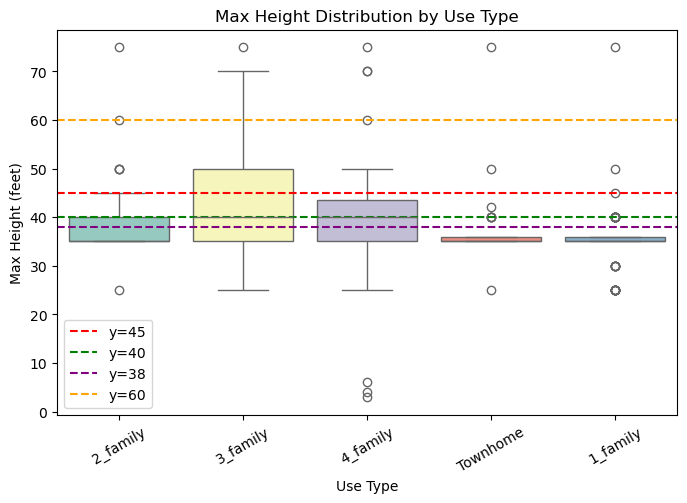

In [123]:
import seaborn as sns

# Step 1: Parse height data
height_data = []
for constraints in height_constraints:
    if isinstance(constraints, dict) and 'height' in constraints:
        for entry in constraints['height']:
            use_names = entry.get('use_name', [])
            max_val = entry.get('max_val')

            # Handle max_val: it could be a dictionary or a list
            if isinstance(max_val, list):  # Handle case where max_val is a list
                max_val = max_val[0] if len(max_val) > 0 else {}
            
            # Extract height value
            if isinstance(max_val, dict):
                if 'expression' in max_val:
                    height_value = max_val['expression']
                elif 'expressions' in max_val:
                    height_value = max(max_val['expressions'])  # Take the maximum value
                else:
                    height_value = None
            else:
                height_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if height_value:
                for use in use_names:
                    try:
                        height_data.append({'use_name': use, 'height': float(height_value)})
                    except ValueError:
                        pass  # Ignore values that cannot be converted

# Step 2: Convert to DataFrame
height_df = pd.DataFrame(height_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = height_df[height_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='height', data=filtered_df, palette="Set3")

# Step 5: Add reference lines
for y_value, color, label in zip([45, 40, 38, 60], ['red', 'green', 'purple', 'orange'], ['y=45', 'y=40', 'y=38', 'y=60']):
    plt.axhline(y=y_value, color=color, linestyle='--', label=label)

# Step 6: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Max Height (feet)")
plt.title("Max Height Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the bedrooms

In [ ]:
bedrooms_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'bedrooms' in key.lower()} if isinstance(x, dict) else {}
)
bedrooms_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

##### Check the unit density

In [113]:
unit_density_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'unit_density' in key.lower()} if isinstance(x, dict) else {}
)
unit_density_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_22020\2265464215.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='unit_density', data=filtered_df, palette="Set3")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


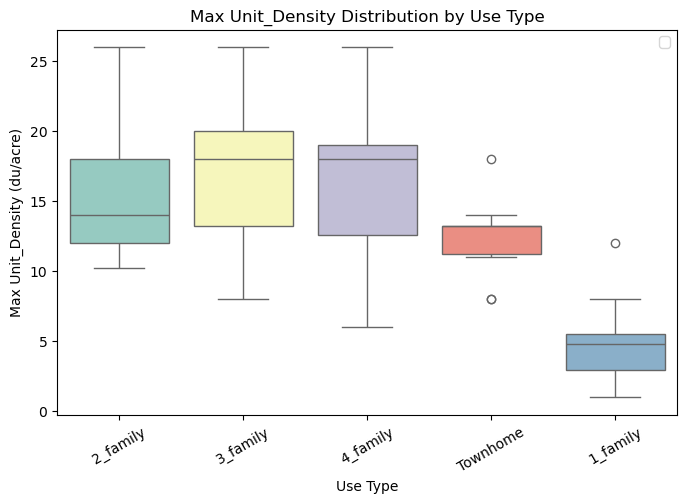

In [120]:
import seaborn as sns

# Step 1: Parse unit_density data
unit_density_data = []
for constraints in unit_density_constraints:
    if isinstance(constraints, dict) and 'unit_density' in constraints:
        for entry in constraints['unit_density']:
            use_names = entry.get('use_name', [])
            max_val = entry.get('max_val')

            # Handle max_val: it could be a dictionary or a list
            if isinstance(max_val, list):  # Handle case where max_val is a list
                max_val = max_val[0] if len(max_val) > 0 else {}
            
            # Extract unit_density value
            if isinstance(max_val, dict):
                if 'expression' in max_val:
                    unit_density_value = max_val['expression']
                elif 'expressions' in max_val:
                    unit_density_value = max(max_val['expressions'])  # Take the maximum value
                else:
                    unit_density_value = None
            else:
                unit_density_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if unit_density_value:
                for use in use_names:
                    try:
                        unit_density_data.append({'use_name': use, 'unit_density': float(unit_density_value)})
                    except ValueError:
                        pass  # Ignore values that cannot be converted

# Step 2: Convert to DataFrame
unit_density_df = pd.DataFrame(unit_density_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = unit_density_df[unit_density_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='unit_density', data=filtered_df, palette="Set3")

# Step 5: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Max Unit_Density (du/acre)")
plt.title("Max Unit_Density Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the unit size

In [115]:
unit_size_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'unit_size' in key.lower()} if isinstance(x, dict) else {}
)
unit_size_constraints

0      {'unit_size': [{'unit': 'square feet', 'use_na...
1      {'unit_size': [{'unit': 'square feet', 'use_na...
2      {'unit_size': [{'unit': 'square feet', 'use_na...
3                                                     {}
4                                                     {}
                             ...                        
276                                                   {}
277                                                   {}
278                                                   {}
279                                                   {}
280                                                   {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_22020\1915614829.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='unit_size', data=filtered_df, palette="Set3")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


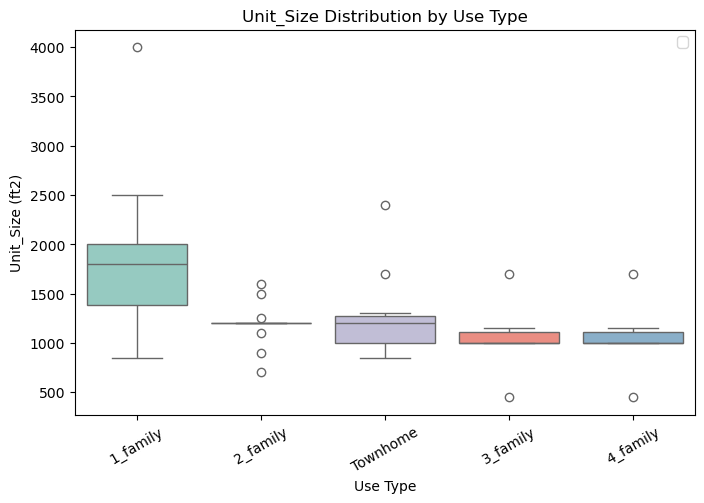

In [ ]:
import seaborn as sns
import re

# Step 1: Parse unit_size data
unit_size_data = []
bedrooms = 6  # Default bedrooms=6

for constraints in unit_size_constraints:
    if isinstance(constraints, dict) and 'unit_size' in constraints:
        for entry in constraints['unit_size']:
            use_names = entry.get('use_name', [])
            min_val = entry.get('min_val')

            # Handle min_val: it could be a dictionary or a list
            if isinstance(min_val, list):  
                min_val = min_val[0] if len(min_val) > 0 else {}

            # Extract expression
            if isinstance(min_val, dict) and 'expression' in min_val:
                raw_expr = min_val['expression']
                
                # Skip "NA" values
                if raw_expr == 'NA':
                    continue
                
                # Handle "0/1 BR: 600; 2 BR: 800; 3BR: 1000"
                if re.search(r'3BR:\s*\d+', raw_expr):
                    match = re.search(r'3BR:\s*(\d+)', raw_expr)
                    unit_size_value = float(match.group(1)) if match else None
                
                # Handle "800 + 150 * bedrooms" calculation
                elif re.search(r'bedrooms', raw_expr):
                    try:
                        unit_size_value = eval(raw_expr.replace("bedrooms", str(bedrooms)))
                    except:
                        unit_size_value = None
                
                # Handle regular numeric values
                else:
                    try:
                        unit_size_value = float(raw_expr)
                    except ValueError:
                        unit_size_value = None
            else:
                unit_size_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if unit_size_value:
                for use in use_names:
                    try:
                        unit_size_data.append({'use_name': use, 'unit_size': unit_size_value})
                    except ValueError:
                        pass  # Ignore values that cannot be converted
                    
# Step 2: Convert to DataFrame
unit_size_df = pd.DataFrame(unit_size_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = unit_size_df[unit_size_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='unit_size', data=filtered_df, palette="Set3")

# Step 5: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Min Unit_Size (ft2)")
plt.title("Min Unit_Size Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the Far

In [125]:
far_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'far' in key.lower()} if isinstance(x, dict) else {}
)
far_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_22020\2235503832.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='use_name', y='far', data=filtered_df, palette="Set3")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


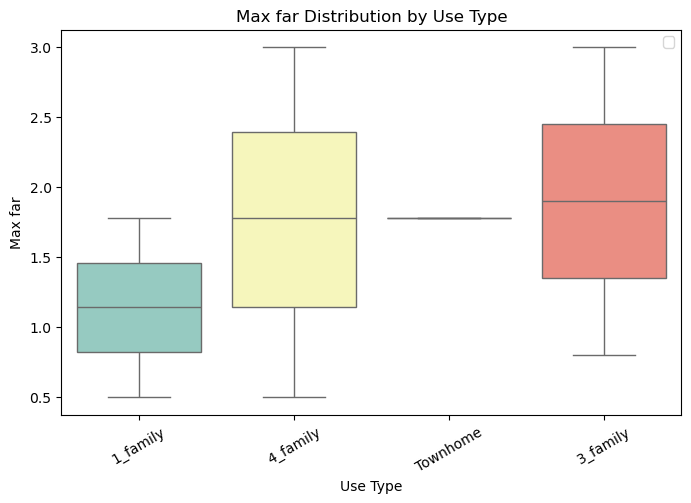

In [126]:
import seaborn as sns

# Step 1: Parse far data
far_data = []
for constraints in far_constraints:
    if isinstance(constraints, dict) and 'far' in constraints:
        for entry in constraints['far']:
            use_names = entry.get('use_name', [])
            max_val = entry.get('max_val')

            # Handle max_val: it could be a dictionary or a list
            if isinstance(max_val, list):  # Handle case where max_val is a list
                max_val = max_val[0] if len(max_val) > 0 else {}
            
            # Extract far value
            if isinstance(max_val, dict):
                if 'expression' in max_val:
                    far_value = max_val['expression']
                elif 'expressions' in max_val:
                    far_value = max(max_val['expressions'])  # Take the maximum value
                else:
                    far_value = None
            else:
                far_value = None

            # Ensure use_names is a list
            if isinstance(use_names, str):
                use_names = [use_names]

            # Record data
            if far_value:
                for use in use_names:
                    try:
                        far_data.append({'use_name': use, 'far': float(far_value)})
                    except ValueError:
                        pass  # Ignore values that cannot be converted

# Step 2: Convert to DataFrame
far_df = pd.DataFrame(far_data)

# Step 3: Keep only the housing types of interest
selected_types = ['1_family', '2_family', '3_family', '4_family', 'Townhome']
filtered_df = far_df[far_df['use_name'].isin(selected_types)]

# Step 4: Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='use_name', y='far', data=filtered_df, palette="Set3")

# Step 5: Beautify the chart
plt.xlabel("Use Type")
plt.ylabel("Max far")
plt.title("Max far Distribution by Use Type")
plt.legend()
plt.xticks(rotation=30)

# Step 7: Show the chart
plt.show()

##### Check the Lot_coverage

In [127]:
lot_coverage_constraints = tidyzoning['structure_constraints'].apply(
    lambda x: {key: value for key, value in x.items() if 'lot_coverage' in key.lower()} if isinstance(x, dict) else {}
)
lot_coverage_constraints

0      {}
1      {}
2      {}
3      {}
4      {}
       ..
276    {}
277    {}
278    {}
279    {}
280    {}
Name: structure_constraints, Length: 281, dtype: object

#### process_zoning_analysis functions

In [26]:
# Run the function
final_results_2_fam = process_zoning_analysis(tidybuilding_2_fam, tidyzoning, tidyparcel)
final_results_2_fam

Processing Parcels: 100%|██████████| 1880/1880 [00:11<00:00, 158.98it/s]


Total parcels: 196296
Total allowed parcels: 1879
Total fitted parcels: 323
Percentage of fitted parcels in total allowed parcels: 17.19%
Percentage of fitted parcels in total parcels: 0.16%


,Prop_ID,parcel_id,allowed
0,14008500020010000,100208,True
1,14008500020130000,100212,False
2,24213500030010000,100353,True
3,14008500030030000,100396,True
4,14008500020080000,100413,True
...,...,...,...
1874,14000500150030000,99738,False
1875,14000500040090000,99739,False
1876,14000500030110000,99918,True
1877,14000500150010000,99934,False


In [27]:
# Run the function
final_results_4_fam_tall = process_zoning_analysis(tidybuilding_4_fam_tall, tidyzoning, tidyparcel)
final_results_4_fam_tall

Processing Parcels: 100%|██████████| 2699/2699 [00:21<00:00, 127.49it/s]


Total parcels: 196296
Total allowed parcels: 2698
Total fitted parcels: 364
Percentage of fitted parcels in total allowed parcels: 13.49%
Percentage of fitted parcels in total parcels: 0.19%


,Prop_ID,parcel_id,allowed
0,24213500030010000,100353,True
1,48000500080020000,1013,False
2,48000500220020000,1017,False
3,48000500210010000,1023,True
4,24214500010070000,102876,True
...,...,...,...
2693,24013500010010000,85787,True
2694,65051911010080000,87044,True
2695,65079862517020000,87054,False
2696,14084500010010100,90397,False


In [28]:
# Run the function
final_results_4_fam_wide = process_zoning_analysis(tidybuilding_4_fam_wide, tidyzoning, tidyparcel)
final_results_4_fam_wide

Processing Parcels: 100%|██████████| 2700/2700 [00:19<00:00, 135.60it/s]


Total parcels: 196296
Total allowed parcels: 2699
Total fitted parcels: 277
Percentage of fitted parcels in total allowed parcels: 10.26%
Percentage of fitted parcels in total parcels: 0.14%


,Prop_ID,parcel_id,allowed
0,24213500030010000,100353,True
1,48000500080020000,1013,False
2,48000500220020000,1017,False
3,48000500210010000,1023,True
4,24214500010070000,102876,True
...,...,...,...
2694,24013500010010000,85787,True
2695,65051911010080000,87044,False
2696,65079862517020000,87054,False
2697,14084500010010100,90397,False


In [29]:
# Run the function
final_results_12_fam = process_zoning_analysis(tidybuilding_12_fam, tidyzoning, tidyparcel)
final_results_12_fam

Processing Parcels: 100%|██████████| 1875/1875 [00:13<00:00, 142.72it/s]


Total parcels: 196296
Total allowed parcels: 1874
Total fitted parcels: 131
Percentage of fitted parcels in total allowed parcels: 6.99%
Percentage of fitted parcels in total parcels: 0.07%


,Prop_ID,parcel_id,allowed
0,48000500080020000,1013,False
1,48000500220020000,1017,False
2,48000500210010000,1023,True
3,65054150510340000,110735,True
4,48000500070010000,1223,True
...,...,...,...
1869,65022661010340000,7425,False
1870,65051911010080000,87044,False
1871,65079862517020000,87054,False
1872,14084500010010100,90397,False
